In [1]:
# blocks output in Colab 
%%capture
!pip install datasets transformers
!pip install timm 
!pip install einops==0.4.1

In [2]:
import os
import numpy as np # linear algebra
from datasets import load_dataset
import torch
from tqdm import tqdm
from transformers import DeiTFeatureExtractor
from timm.loss import LabelSmoothingCrossEntropy
feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-tiny-patch16-224")
ds = load_dataset('beans')
ds

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [5]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [12]:
list_bean_rust = []
for i in range(len(ds['validation'])):
  ex = ds['validation'][i]
  if labels.int2str(ex['labels']) == 'bean_rust':
    list_bean_rust.append(i)
print(list_bean_rust)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


bean_rust


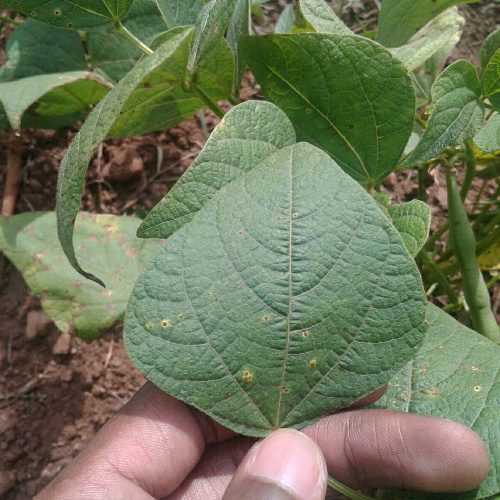

In [40]:
ex = ds['validation'][19]
image = ex['image']
print(labels.int2str(ex['labels']))
image

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

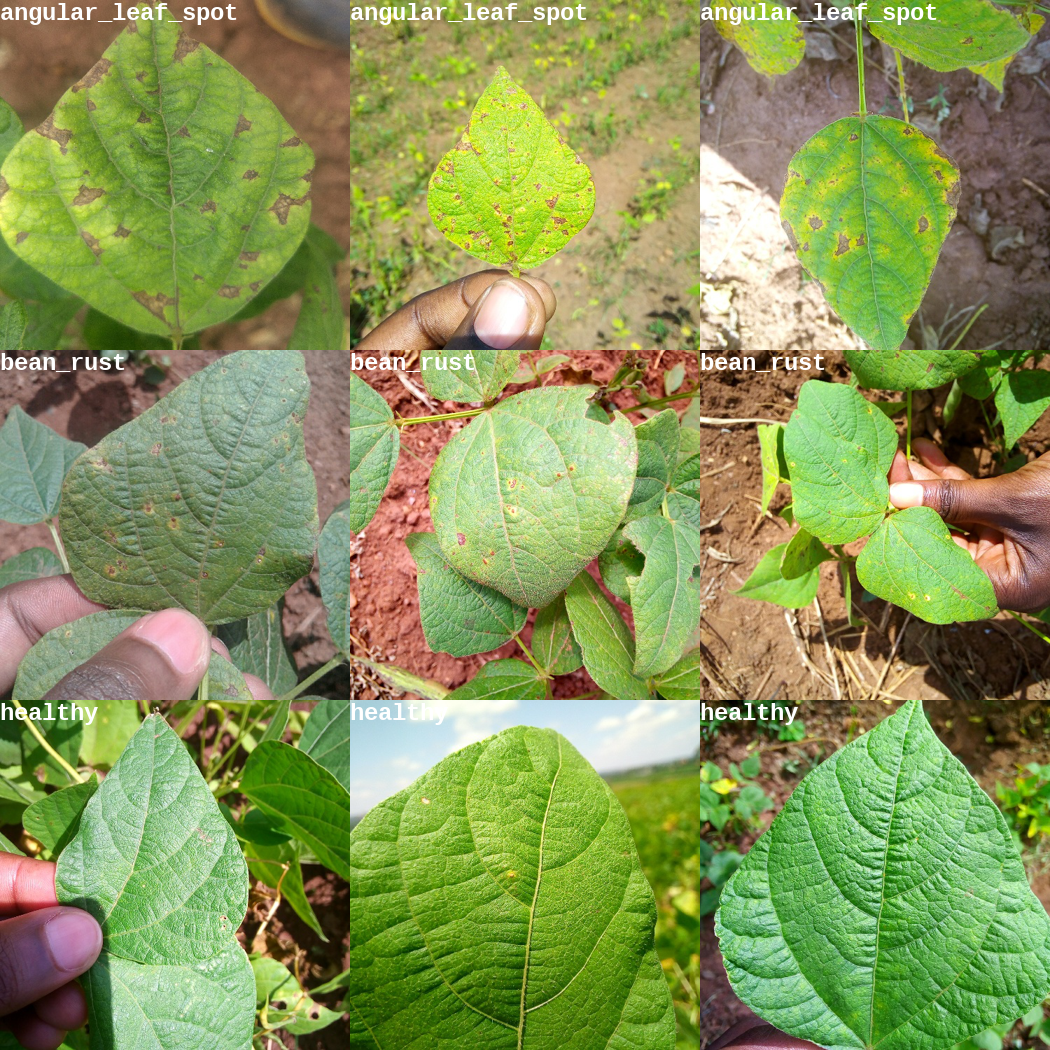

In [3]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [3]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

In [4]:
def transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

In [5]:
dataset = ds.with_transform(transforms)

In [6]:
from torch.utils.data import DataLoader

def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["pixel_values"]))
        labels.append(example["labels"])
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return [pixel_values, labels]

train_dataloader = DataLoader(dataset['train'], collate_fn=collate_fn, batch_size=32,shuffle=True, num_workers=2)
test_dataloader = DataLoader(dataset['test'], collate_fn=collate_fn, batch_size=16,shuffle=False, num_workers=2)
val_dataloader = DataLoader(dataset['validation'], collate_fn=collate_fn, batch_size=16,shuffle=False, num_workers=2)

In [7]:
imgs_view, labels_view = next(iter(train_dataloader))
imgs_view[5].shape, labels_view[5].item()

(torch.Size([3, 224, 224]), 0)

In [8]:
labels = ds['train'].features['labels']
labels.names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [9]:
# to load the model
!git clone https://github.com/TiagoFilipeSousaGoncalves/survey-attention-medical-imaging.git

Cloning into 'survey-attention-medical-imaging'...
remote: Enumerating objects: 1971, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1971 (delta 43), reused 46 (delta 21), pack-reused 1886
Receiving objects: 100% (1971/1971), 728.30 KiB | 21.42 MiB/s, done.
Resolving deltas: 100% (1381/1381), done.


In [10]:
%cd survey-attention-medical-imaging/code

/content/survey-attention-medical-imaging/code


In [11]:
from transformer_explainability_utils.ViT_LRP import deit_tiny_patch16_224 as DeiT_Tiny
from transformer_explainability_utils.ViT_explanation_generator import LRP

In [12]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
# Number of classes for models
nr_classes = len(labels.names)
IMG_SIZE = feature_extractor.size

model = DeiT_Tiny(pretrained=True, num_classes=nr_classes , input_size=(3, IMG_SIZE, IMG_SIZE), url="https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth")
attribution_generator = LRP(model, device)

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


Model loaded with success.


In [14]:
model.eval
model = model.to(device)

In [15]:
# go back to root
%cd /content

/content


In [16]:
learning_rate = 0.03
scheduler_step = 5
scheduler_gamma = 0.97
optimizer = torch.optim.Adam(model.head.parameters(), lr=learning_rate)
criterion = LabelSmoothingCrossEntropy() 
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
def fit(model, train, test , epochs=10):
    model.to(device)

    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(train)
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            exp_lr_scheduler.step()
            bar.set_description(f"loss     {np.mean(train_loss):.5f} acc     {np.mean(train_acc):.5f}")
        bar = tqdm(test)
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        #wandb.log({'Val accuracy': np.mean(val_acc), 'val loss': np.mean(val_loss)})

        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}\n")

In [17]:
'''
wandb.init( project="deit_tiny_patch16_224__flowers")

config = wandb.config          
config.batch_size = batch_size          
config.test_batch_size = batch_size    
config.epochs = 10              
config.lr = learning_rate
config.scheduler_step =scheduler_step
config.scheduler_gamma =scheduler_gamma    
'''
fit(model, train_dataloader, test_dataloader)

val_loss 1.11387 val_acc 0.63281: 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]



Epoch 1/10 loss 1.34494 val_loss 1.11387 acc 0.63617 val_acc 0.63281



val_loss 0.66490 val_acc 0.80469: 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]



Epoch 2/10 loss 0.72195 val_loss 0.66490 acc 0.78106 val_acc 0.80469



val_loss 0.58866 val_acc 0.84375: 100%|██████████| 8/8 [00:01<00:00,  6.78it/s]



Epoch 3/10 loss 0.60100 val_loss 0.58866 acc 0.83750 val_acc 0.84375



val_loss 0.61799 val_acc 0.85938: 100%|██████████| 8/8 [00:01<00:00,  6.87it/s]



Epoch 4/10 loss 0.57427 val_loss 0.61799 acc 0.85473 val_acc 0.85938



val_loss 0.61053 val_acc 0.83594: 100%|██████████| 8/8 [00:01<00:00,  6.59it/s]



Epoch 5/10 loss 0.57971 val_loss 0.61053 acc 0.84981 val_acc 0.83594



val_loss 0.55806 val_acc 0.87500: 100%|██████████| 8/8 [00:01<00:00,  6.58it/s]



Epoch 6/10 loss 0.58289 val_loss 0.55806 acc 0.84678 val_acc 0.87500



val_loss 0.63189 val_acc 0.82031: 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]



Epoch 7/10 loss 0.57408 val_loss 0.63189 acc 0.85189 val_acc 0.82031



val_loss 0.54973 val_acc 0.84375: 100%|██████████| 8/8 [00:01<00:00,  6.85it/s]



Epoch 8/10 loss 0.56116 val_loss 0.54973 acc 0.87083 val_acc 0.84375



val_loss 0.54509 val_acc 0.88281: 100%|██████████| 8/8 [00:01<00:00,  6.77it/s]



Epoch 9/10 loss 0.55174 val_loss 0.54509 acc 0.85758 val_acc 0.88281



val_loss 0.59283 val_acc 0.82812: 100%|██████████| 8/8 [00:01<00:00,  6.54it/s]


Epoch 10/10 loss 0.54874 val_loss 0.59283 acc 0.86402 val_acc 0.82812



In [18]:
test_loss = 0.0
class_correct = list(0 for i in range(len(labels.names)))
class_total = list(0 for i in range(len(labels.names)))
model.eval()
levels = labels.names

for data, target in tqdm(val_dataloader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 16:
        for i in range(16):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / len(val_dataloader)
print('\nTest Loss: {:.4f}'.format(test_loss))
for i in range(3):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            levels[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (labels.name[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 9/9 [00:01<00:00,  6.61it/s]


Test Loss: 0.2554
Test Accuracy of angular_leaf_spot: 88% (39/44)
Test Accuracy of bean_rust: 80% (36/45)
Test Accuracy of healthy: 97% (38/39)
Test Accuracy of 88% (113/128)


In [29]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def show_cam_on_image_plus(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    #cam = heatmap + np.float32(img)
    cam = heatmap
    cam = cam / np.max(cam)
    return cam
    
def generate_visualization_plus(original_image, class_index=None , plus=False):
    transformer_attribution = attribution_generator.generate_attribution(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    if plus:
      vis = show_cam_on_image_plus(image_transformer_attribution, transformer_attribution)
    else:
      vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions):    # **kwargs
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(3, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(myClass[cls_idx])
        if len(myClass[cls_idx]) > max_str_len:
            max_str_len = len(myClass[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, myClass[cls_idx])
        output_string += ' ' * (max_str_len - len(myClass[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)
    print("")

In [20]:
attribution_generator = LRP(model, device)

In [21]:
myClass = { 0: 'angular_leaf_spot',
            1: 'bean_rust',
            2: 'healthy',
}

Top 5 classes:
	1 : bean_rust        		value = 2.745	 prob = 86.8%
	2 : healthy          		value = 0.747	 prob = 11.8%
	0 : angular_leaf_spot		value = -1.357	 prob = 1.4%



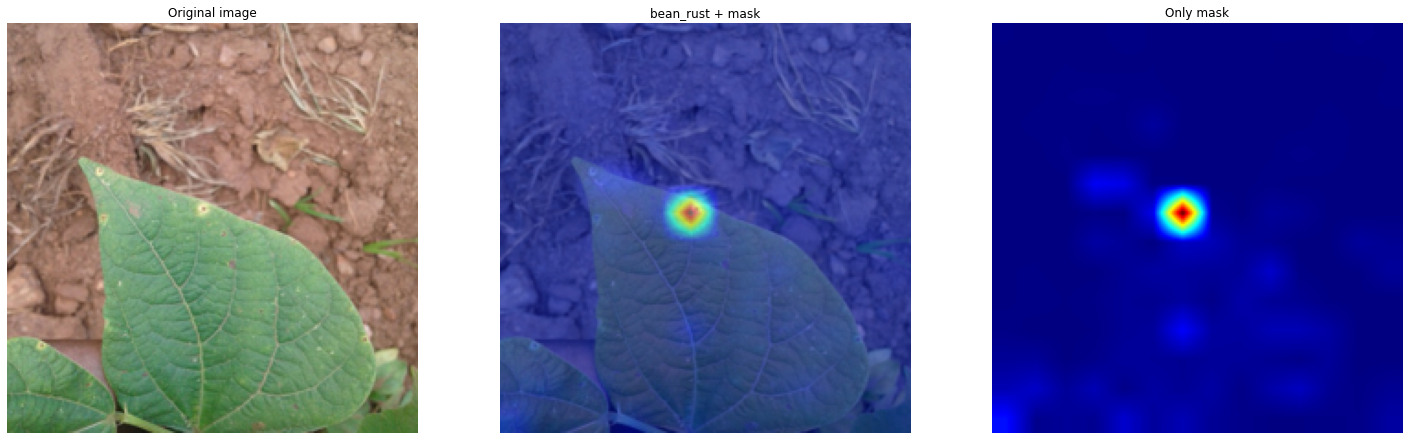

In [112]:
#@title Clases de flores:
val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

chose = 'bean_rust' #@param ["angular_leaf_spot", "bean_rust", "healthy"]

index = list(myClass.values()).index(chose)

#image = Image.open('image.jpg')
#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
#  1 -4- 5 7 17 -23- 25 27 -28- 29 30 31 32 33 35 36 38 40 42 43
ex = ds['validation'][4]
image = ex['image']

newsize = (224, 224)
im1 = image.resize(newsize)
attention_image = val_transforms(image)

output = model(attention_image.unsqueeze(0).cuda())


fig, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].title.set_text('Original image')
axs[0].imshow(im1);
axs[0].axis('off');

print_top_classes(output)


# zebra 
# zebra- the predicted class
our_1 = generate_visualization_plus(attention_image, class_index=index)

# generate visualization for class 101: 'tusker'
our_2 = generate_visualization_plus(attention_image, class_index=index, plus=True)

axs[1].title.set_text(f'{chose} + mask')
axs[1].imshow(our_1);
axs[1].axis('off');
axs[2].imshow(our_2);
axs[2].title.set_text('Only mask')
axs[2].axis('off');